In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 6,555 B in 1s (4,944 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... D

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# Discretization
def discretize_state(state, bins):

  cart_pos_bin = np.digitize(state[0], bins[0])
  cart_vel_bin = np.digitize(state[1], bins[1])
  pole_ang_bin = np.digitize(state[2], bins[2])
  pole_vel_bin = np.digitize(state[3], bins[3])

  return (cart_pos_bin, cart_vel_bin, pole_ang_bin, pole_vel_bin)

bins = [
  np.linspace(-2.4, 2.4, 4),     # car position
  np.linspace(-2, 2, 8),       # car velocity
  np.linspace(-0.2095, 0.2095, 10),  # pole angle
  np.linspace(-5, 5, 10)       # pole angular velocity
]

Reward using trained policy: 171.0


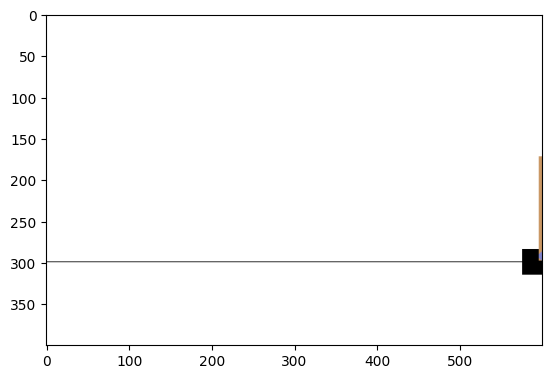

In [ ]:
# on-policy SARSA
env = gym.make("CartPole-v0")
stateSpaceSize = (len(bins[0])+1, len(bins[1])+1, len(bins[2])+1, len(bins[3])+1)
actionSpaceSize = env.action_space.n
Q = np.zeros(stateSpaceSize + (actionSpaceSize,))
gamma, episodes, alpha, epsilon = 0.99, 10000, 0.1, 0.1

for episode in range(episodes):
  state = env.reset()
  state = discretize_state(state, bins)
  done = False

  # choose A from S using epsilon-greedy policy derived from Q
  if np.random.rand() < epsilon:
    action = np.random.choice(actionSpaceSize)
  else:
    action = np.argmax(Q[state])

  while not done:
    next_state, reward, done, _ = env.step(action)
    next_state = discretize_state(next_state, bins)
    # choose A' from S' using epsilon-greedy policy derived from Q (on-policy)
    if np.random.rand() < epsilon:
      next_action = np.random.choice(actionSpaceSize)
    else:
      next_action = np.argmax(Q[next_state])
    Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
    state, action = next_state, next_action

state = env.reset()
state = discretize_state(state, bins)
done = False
i, total_reward = 0, 0
while not done:
  env.render()
  action = np.argmax(Q[state])
  print("step i",i,"action=",action)
  i += 1
  state, reward, done, info = env.step(action)
  print("obs=",state,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  state = discretize_state(state, bins)
  total_reward += reward
ipythondisplay.clear_output(wait=True)
print('Reward using trained policy:', total_reward)
env.close()

Reward using trained policy: 174.0


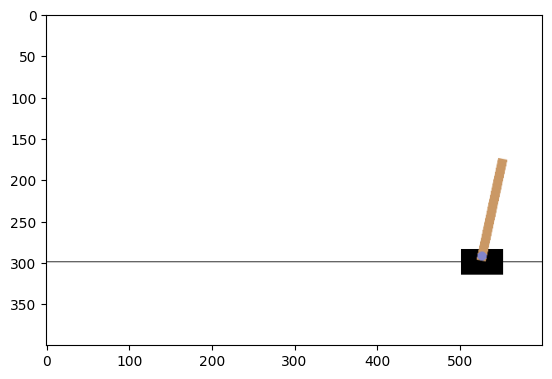

In [ ]:
# off-policy Q learning
env = gym.make("CartPole-v0")
stateSpaceSize = (len(bins[0])+1, len(bins[1])+1, len(bins[2])+1, len(bins[3])+1)
actionSpaceSize = env.action_space.n
# as the initialization of Q can be arbitrary and the terminal state should be zero, here I directly initialize it to be all zero.
Q = np.zeros(stateSpaceSize + (actionSpaceSize,))
gamma, episodes, alpha, epsilon = 0.99, 10000, 0.1, 0.1

for episode in range(episodes):
  state = env.reset()
  state = discretize_state(state, bins)
  done = False

  while not done:
    if np.random.rand() < epsilon:
      action = np.random.choice(actionSpaceSize)
    else:
      action = np.argmax(Q[state])
    next_state, reward, done, _ = env.step(action)
    next_state = discretize_state(next_state, bins)
    # compute max Q(S') (off-policy Q-learning)
    max_next_Q = np.max(Q[next_state])
    Q[state][action] += alpha * (reward + gamma * max_next_Q - Q[state][action])
    state = next_state

state = env.reset()
state = discretize_state(state, bins)
done = False
i, total_reward = 0, 0
while not done:
  env.render()
  action = np.argmax(Q[state])
  print("step i",i,"action=",action)
  i += 1
  state, reward, done, info = env.step(action)
  print("obs=",state,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  state = discretize_state(state, bins)
  total_reward += reward
ipythondisplay.clear_output(wait=True)
print('Reward using trained policy:', total_reward)
env.close()

Reward using trained policy: 200.0


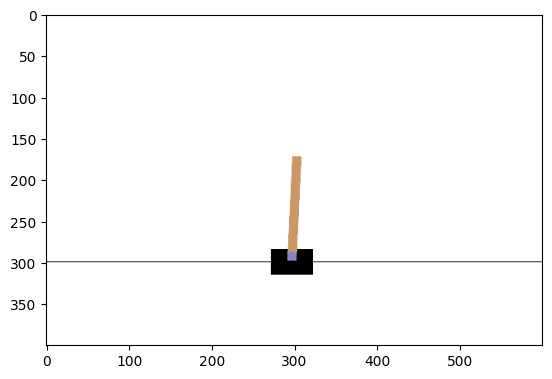

In [ ]:
# off-policy Expected SARSA with an epsilon-greedy policy
env = gym.make("CartPole-v0")
stateSpaceSize = (len(bins[0])+1, len(bins[1])+1, len(bins[2])+1, len(bins[3])+1)
actionSpaceSize = env.action_space.n
Q = np.zeros(stateSpaceSize + (actionSpaceSize,))
gamma, episodes, alpha, epsilon = 0.99, 10000, 0.1, 0.1

for episode in range(episodes):
  state = env.reset()
  state = discretize_state(state, bins)
  done = False

  while not done:
    # epsilon-greedy
    if np.random.rand() < epsilon:
      action = np.random.choice(actionSpaceSize)
    else:
      action = np.argmax(Q[state])
    next_state, reward, done, _ = env.step(action)
    next_state = discretize_state(next_state, bins)
    # e-SARSA (off-policy)
    expected_Q = 0
    for next_action in range(actionSpaceSize):
      if next_action == np.argmax(Q[next_state]):
        expected_Q += (1 - epsilon + epsilon / actionSpaceSize) * Q[next_state][next_action]
      else:
        expected_Q += (epsilon / actionSpaceSize) * Q[next_state][next_action]
    Q[state][action] += alpha * (reward + gamma * expected_Q - Q[state][action])
    state = next_state

state = env.reset()
state = discretize_state(state, bins)
done = False
i, total_reward = 0, 0
while not done:
  env.render()
  action = np.argmax(Q[state])
  print("step i",i,"action=",action)
  i += 1
  state, reward, done, info = env.step(action)
  print("obs=",state,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  state = discretize_state(state, bins)
  total_reward += reward
ipythondisplay.clear_output(wait=True)
print('Reward using trained policy:', total_reward)
env.close()

After 10,000 episodes, all three methods achieved 170+ rewards.
Comparing to the model performances of MC in the previous task (best reward is around 100 after more episodes), TD(0) seems to be a better option for CartPole.
From my understanding, that is mainly because MC updates Q after a whole episode while that of TD is step-by-step, which makes the latter more efficient.
Among the three methods above, e-SARSA has the best performance of full mark 200.
It combines the advantages of both Q-learning and SARSA, which can further improve stability and convergence speed.